<a href="https://colab.research.google.com/github/LeonardoSanBenitez/Unlearn-Saliency/blob/master/PEM_composition_img_gen/01_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

is_colab: bool = 'google.colab' in sys.modules

if is_colab:
    # You need to manually create the .env file
    %cd /content
    !pip install python-dotenv
    import dotenv
    dotenv.load_dotenv()

    import os
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    # TODO: install the dependencies from our repo, not from difusers
    if not os.path.exists('diffusers'):
        !git clone https://github.com/huggingface/diffusers
    %cd diffusers
    !pip install .
    !pip install torchmetrics

    %cd examples/text_to_image
    !pip install -r requirements.txt

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default

    %cd /content/
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd /content/Unlearn-Saliency/PEM_composition_img_gen
elif "alumnos" in os.getcwd():
    %cd ~
    if not os.path.exists('Unlearn-Saliency'):
        !git clone https://github.com/LeonardoSanBenitez/Unlearn-Saliency.git
    %cd ~/Unlearn-Saliency/PEM_composition_img_gen

    !python3.10 -m pip install poetry~=1.2
    !python3.10 -m poetry config virtualenvs.create true

    if os.path.exists("poetry.lock"):
        !rm poetry.lock
    !sed -i 's/python = "~3.11"/python = "~3.10"/' ./pyproject.toml
    !python3.10 -m poetry install --no-root --no-interaction --no-ansi
    
    import dotenv
    dotenv.load_dotenv()
    assert (os.getenv("HF_TOKEN") is not None) and (len(os.getenv("HF_TOKEN"))>0)

    !huggingface-cli login --token ${HF_TOKEN}
    !accelerate config default
else:
    sys.path.append('..')  # TODO: configure this at apptainer level
    user = os.getenv('USER')
    %cd /home/{user}/Unlearn-Saliency/PEM_composition_img_gen

/home/benle1/Unlearn-Saliency/PEM_composition_img_gen


In [2]:
import datasets
from PIL import Image
import matplotlib.pyplot as plt
import random
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from typing import Literal, List, Dict, Tuple, Optional, Callable, Union

import os
import sys
import shutil

from libs.datasets import UnlearnDatasetImagenette, UnlearnDatasetCifar, UnlearnDatasetSplitMode, UnlearnDatasetSplit
from libs.utils.training import launch_accelerated_training
from libs.unlearner import UnlearnerLora
from libs.utils.logger import get_logger, setup_loggers
from libs.utils.gradient_weighting import GradientWeightingMethodMunba


logger = get_logger('main')
setup_loggers(modules_info=['libs.'])

In [3]:
model_base_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"

# Download dataset

In [25]:
#if os.path.exists('assets/imagenette_splits'):
#    shutil.rmtree('assets/imagenette_splits')
if not os.path.exists('assets/imagenette_splits'):
    for c in UnlearnDatasetImagenette.class_mapping:
        print('-'*80)
        print('Forgetting', UnlearnDatasetImagenette.class_mapping[c])
        dataset = UnlearnDatasetImagenette(
            split_mode=UnlearnDatasetSplitMode.Class,
            split_kwargs={"forget": [c]},
            download_path="assets/imagenette",
        )
        
        dataset.save(f"assets/imagenette_splits/{c}", format='jpg')

--------------------------------------------------------------------------------
Forgetting tench
Dataset already downloaded and extracted. Skipping download.


# Train

In [4]:
!nvidia-smi

Fri Mar 21 18:12:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           Off |   00000000:18:00.0 Off |                    0 |
| N/A   44C    P0             40W /  250W |       1MiB /  16384MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


--------------------------------------------------------------------------------
Training tench
[2025-03-21 18:12:27 +0100] libs.trainer INFO     Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



Resolving data files:   0%|          | 0/868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7659 [00:00<?, ?it/s]

[2025-03-21 18:12:40 +0100] libs.trainer INFO     ***** Running training *****
[2025-03-21 18:12:40 +0100] libs.trainer INFO       Num examples = 867 + 7658
[2025-03-21 18:12:40 +0100] libs.trainer INFO       Num Epochs = 5
[2025-03-21 18:12:40 +0100] libs.trainer INFO       Instantaneous batch size per device = 4
[2025-03-21 18:12:40 +0100] libs.trainer INFO       Total train batch size (w. parallel, distributed & accumulation) = 32
[2025-03-21 18:12:40 +0100] libs.trainer INFO       Gradient Accumulation steps = 8
[2025-03-21 18:12:40 +0100] libs.trainer INFO       Total optimization steps = 140


Steps:   0%|          | 0/140 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 18:18:24 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 18:25:53 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 18:33:48 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 18:42:02 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 18:49:57 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-03-21 18:50:04 +0100] libs.evaluation INFO     Running validation... 
 Generating 1 images with prompt: Picture of a tench.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/home/benle1/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/benle1/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/

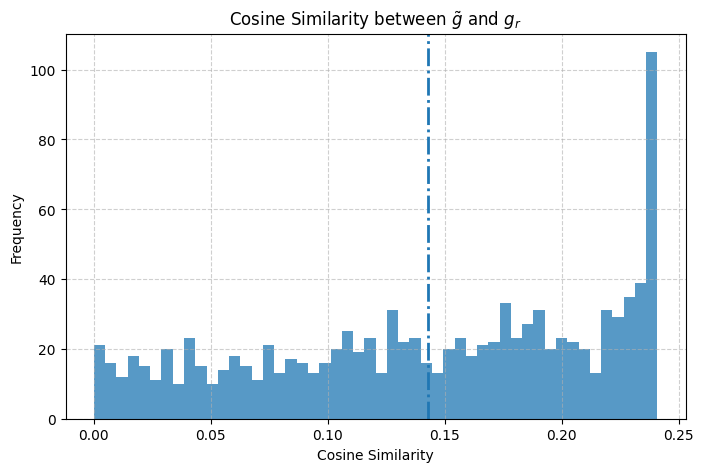

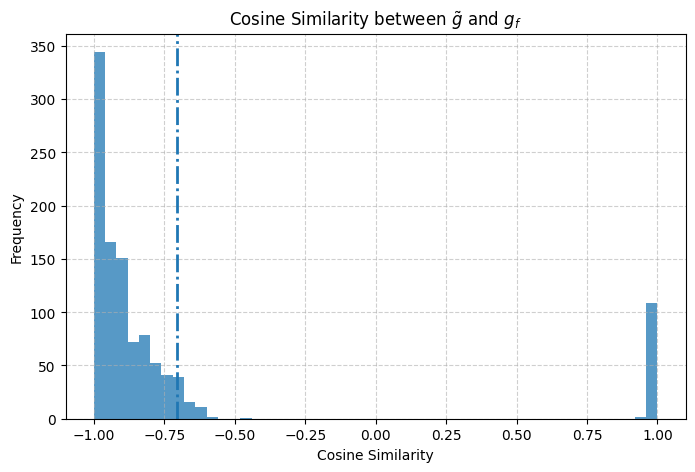

In [5]:
for c in UnlearnDatasetImagenette.class_mapping:
    print('-'*80)
    print('Training', UnlearnDatasetImagenette.class_mapping[c])
    dataset_forget_name = f"./assets/imagenette_splits/{c}/train_forget"
    dataset_retain_name = f"./assets/imagenette_splits/{c}/train_retain"
    output_dir = f"./assets/lora/imagenette_splits/{c}"
    
    launch_accelerated_training(unlearner=UnlearnerLora(
        pretrained_model_name_or_path=model_base_name,
        dataset_forget_name=dataset_forget_name,
        dataset_retain_name=dataset_retain_name,
        dataloader_num_workers=2,
        resolution=512,
        mixed_precision="fp16",
        train_batch_size=4,
        gradient_accumulation_steps=8,
        learning_rate=2e-4,
        max_grad_norm=1.0,
        lr_scheduler="cosine",
        lr_warmup_steps=0,
        output_dir=output_dir,
        num_train_epochs=5,
        validation_epochs=1,
        checkpointing_steps=500,
        validation_prompt=f"Picture of a {UnlearnDatasetImagenette.class_mapping[c]}",
        num_validation_images=1,
        seed=42,
        gradient_weighting_method = GradientWeightingMethodMunba(),
    ))

    break

# Evaluation

--------------------------------------------------------------------------------
Evaluating tench


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

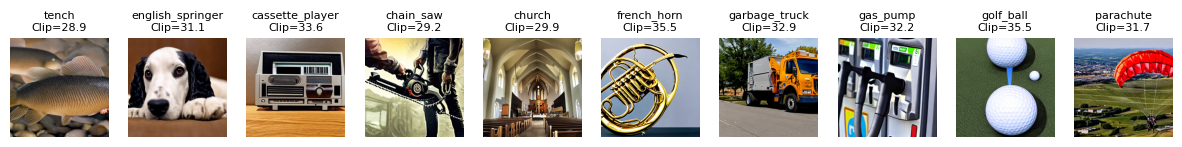

In [6]:
from libs.metrics.image_and_text import MetricImageTextSimilarity
metric = MetricImageTextSimilarity(metrics=['clip'])

for class_model in UnlearnDatasetImagenette.class_mapping:
    print('-'*80)
    print('Evaluating', UnlearnDatasetImagenette.class_mapping[class_model])

    output_dir = f"./assets/lora/imagenette_splits/{class_model}"
    pipeline_unlearned = AutoPipelineForText2Image.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")
    pipeline_unlearned.load_lora_weights(output_dir, weight_name="pytorch_lora_weights.safetensors")

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for col, class_eval in enumerate(UnlearnDatasetImagenette.class_mapping):
        prompt = f"An image of {UnlearnDatasetImagenette.class_mapping[class_eval]}"
        image = pipeline_unlearned(prompt).images[0]
        score_clip: float = metric.score(image, prompt)['clip']

        axes[col].imshow(image)
        axes[col].set_title(f"{UnlearnDatasetImagenette.class_mapping[class_eval]}\nClip={score_clip:.1f}", fontsize=8)
        axes[col].axis("off")
    plt.plot()
    break